# Neuroingeniería e Innovación en Neurociencia. Jupyter Notebook
## Máster en Bioinformática para las Ciencias de la Salud
### Pedro Sánchez García

### --------------------------------------------------------------------------------------------------------------------------------

# Signal processing in BCI

## Initial setup
For this notebook we will need some extra packages, with some old versions, so it is convenient to set up a virtual environment using the `requirements.txt` file. Maximum Python version for these requirements is Python 3.7.

Using standard Python virtual environments this could be done doing the following (there are similar alternatives using Anaconda and the conda utilities)
1. Create a Python 3.7 virtual environment with custom name (e.g. `nin`) in your working directory
```
$ python3.7 -m venv nin
```

2. Activate the virtual environment to configure the custom python installation
```
$ source nin/bin/activate
(nin) $ _
```

3. Now, inside this virtual environment, we can see that there are no python packages (e.g. check `pip freeze` to verify that there are no packages). Verify python version is correct (e.g. `python --version`). Verify that the used python kernel is the one in the virtual environment (e.g. `which python` and `which pip` should return a route in the local directory `nin`).
4. We should upgrade pip, and install some utilities that may speedup the package installation (wheel, setuptools)
```
(nin) $ pip install -U pip wheel setuptools
```

5. Then install the requirements in the virtual environment (check packages after install if you want with (`pip freeze`)
```
(nin) $ pip install -r requirements.txt
```

6. Add the current virtual environment to the ipython kernel with your custom name (e.g. NIN), so that it can be used in jupyter notebooks
```
(nin) $ python -m ipykernel install --user --name=NIN
```

7. We should now see a new kernel available from notebooks called `nin`. We can exit from the virtual environment and open jupyter notebook
```
(nin) $ deactivate
$ jupyter notebook
```

8. At the Notebook environment, you should now see a kernel named `nin` under Kernel>Change kernel>... This kernel will use the custom Python version and package list instead of those by default in the system. We can list and manage jupyter kernels using the `jupyter kernelspec` utility (followed by e.g. `--help`, `list`, `uninstall <name>`, etc.).

In [1]:
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types
import mne
#from mne.viz.topomap import _prepare_topo_plot, plot_topomap

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

import cycler
import itertools


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## Dataset

EEG signals from a motor task with 6 detected events. Description of the dataset:

This data contains EEG recordings of subjects performing grasp-and-lift (GAL) trials. The following video shows an example of a trial:

https://www.youtube.com/watch?v=y3_Izuop2gY

A detailed account of the data can be found in 

Luciw MD, Jarocka E, Edin BB (2014) Multi-channel EEG recordings during 3,936 grasp and lift trials with varying weight and friction. Scientific Data 1:140047. www.nature.com/articles/sdata201447

There are 12 subjects in total, 10 series of trials for each subject, and approximately 30 trials within each series. The number of trials varies for each series. The training set contains the first 8 series for each subject. The test set contains the 9th and 10th series.

For each GAL, you are tasked to detect 6 events:

    HandStart
    FirstDigitTouch
    BothStartLoadPhase
    LiftOff
    Replace
    BothReleased

These events always occur in the same order. In the training set, there are two files for each subject + series combination:

    the *_data.csv files contain the raw 32 channels EEG data (sampling rate 500Hz)
    the *_events.csv files contains the ground truth frame-wise labels for all events

The events files for the test set are not provided and must be predicted. Each timeframe is given a unique id column according to the subject, series, and frame to which it belongs. The six label columns are either zero or one, depending on whether the corresponding event has occurred within ±150ms (±75frames). A perfect submission will predict a probability of one for this entire window.




EEG data is saved in csv files. There is an individual file for each serie, containing 30 trials of the Grasp and Lift task. 

*Note that there are other formats that are specific for temporal series in biomedicine. MNE has utilities to load data from the most common of these formats. Some examples are  European Data Format (EDF), General Data Format (GDF) or the EEGLAB format (a Matlab toolbox)

## Reading the data

### Pandas introduction

Pandas is a Python package with useful tools for data reading, analysis and writing.

We will explore how to read the EEG data and events from the dataset

First, for convenience, we will define the file names for custom subject and series

In [21]:

subject=1
serie=5
fname = './train/subj%d_series%d_data.csv' % (subject,serie)  # Make sure that you adjust the route
f_events = fname.replace('_data', '_events')

print (fname)
print (f_events)


./train/subj1_series5_data.csv
./train/subj1_series5_events.csv


Use Pandas to read the CSV files

In [22]:
data = pd.read_csv(fname)
events = pd.read_csv(f_events)

We can use the resulting Pandas objects to explore the data. For example, we can print the headers

In [4]:
# Information about the columns
data.info()
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210644 entries, 0 to 210643
Data columns (total 33 columns):
id      210644 non-null object
Fp1     210644 non-null int64
Fp2     210644 non-null int64
F7      210644 non-null int64
F3      210644 non-null int64
Fz      210644 non-null int64
F4      210644 non-null int64
F8      210644 non-null int64
FC5     210644 non-null int64
FC1     210644 non-null int64
FC2     210644 non-null int64
FC6     210644 non-null int64
T7      210644 non-null int64
C3      210644 non-null int64
Cz      210644 non-null int64
C4      210644 non-null int64
T8      210644 non-null int64
TP9     210644 non-null int64
CP5     210644 non-null int64
CP1     210644 non-null int64
CP2     210644 non-null int64
CP6     210644 non-null int64
TP10    210644 non-null int64
P7      210644 non-null int64
P3      210644 non-null int64
Pz      210644 non-null int64
P4      210644 non-null int64
P8      210644 non-null int64
PO9     210644 non-null int64
O1      210644 non

Another option is to print the first n rows of data (n=5 by default) using head. Or index and show any desired rows

In [5]:
# Print a table of the first 5 rows
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series5_0,65,164,278,74,-143,449,-196,298,-3,...,201,93,231,403,476,-199,76,171,84,70
1,subj1_series5_1,55,-82,222,129,-152,493,-235,263,10,...,224,86,231,412,481,-140,74,174,123,95
2,subj1_series5_2,13,-207,189,88,-134,539,-200,297,7,...,193,70,239,401,419,-59,98,180,66,-28
3,subj1_series5_3,-39,-98,166,84,-161,463,-253,263,-24,...,135,46,233,410,447,-99,81,193,107,90
4,subj1_series5_4,21,54,255,142,-141,385,-191,269,-40,...,99,31,262,418,449,-219,47,187,115,124


In [6]:
# Print a table of the first 3 rows
events.head(3)

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series5_0,0,0,0,0,0,0
1,subj1_series5_1,0,0,0,0,0,0
2,subj1_series5_2,0,0,0,0,0,0


Print a table with the some desired rows

In [7]:
data[6:10]

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
6,subj1_series5_6,-16,252,268,115,-151,71,-159,355,-15,...,93,60,259,419,410,-133,104,229,150,45
7,subj1_series5_7,68,258,280,133,-143,190,-156,281,-18,...,174,56,277,422,429,-38,130,234,128,25
8,subj1_series5_8,63,208,318,55,-143,303,-196,233,-13,...,183,76,284,437,439,-3,150,266,156,51
9,subj1_series5_9,52,167,357,25,-135,480,-191,259,-14,...,147,80,284,461,478,-59,136,257,179,75


Furthermore, we can plot the desired data

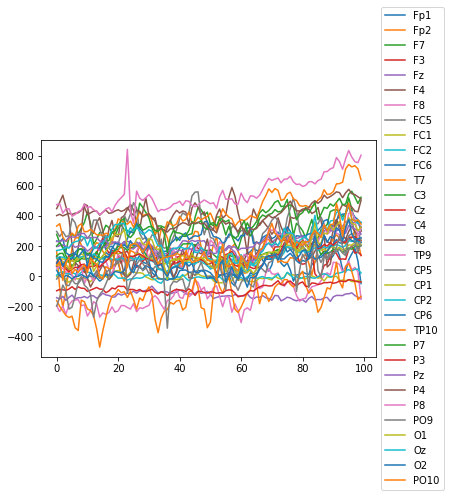

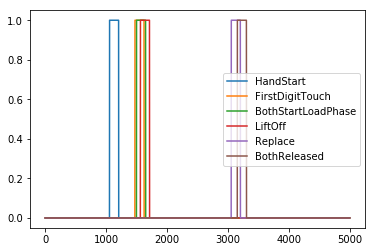

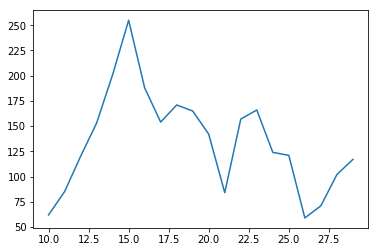

In [5]:
# The data
data[0:100].plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# The events
events[0:5000].plot()
plt.show()

# We can also select columns by the header name, e.g.
data[10:30].F3.plot()


### Reading data in MNE format

Now, we will use the MNE package for exploring and visualizing the data.

As MNE has no specific function for loading from a CSV file, we use the next custom function. which reads the file and creates a MNE Raw object.


In [23]:
# Custom function for loading data from csv to MNE
def create_mne_raw_object_from_csv(fname):
    f_events = fname.replace('_data','_events')
    
    # read EEG file (csv) using Pandas
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)

    # read event file
    events = pd.read_csv(f_events)
    events_names = events.columns[1:]
    events_data = np.array(events[events_names]).T
    
    # concatenate event file and data
    data = np.concatenate((1e-6*np.array(data[ch_names]).T,events_data))        
    
    # define channel type, the first is EEG, the last 6 are stimulations
    ch_type = ['eeg']*len(ch_names) + ['stim']*6
    
    # create and populate MNE info structure
    ch_names.extend(events_names)
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    return raw

## Exploring the MNE Raw data structure

### Basic information

In [24]:
# import the data and check the info: channel names, etc.

raw = create_mne_raw_object_from_csv(fname)
print(raw.info)
print(raw.info['ch_names'])
#print(raw.info['chs'][0])


1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, ...
    chs : list | 38 items (EEG: 32, STIM: 6)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 35 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    nchan : int | 38
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_date : NoneType
    me

<ipython-input-23-aec1cde4f3e1>:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)


### Basic representations of electrodes and signals

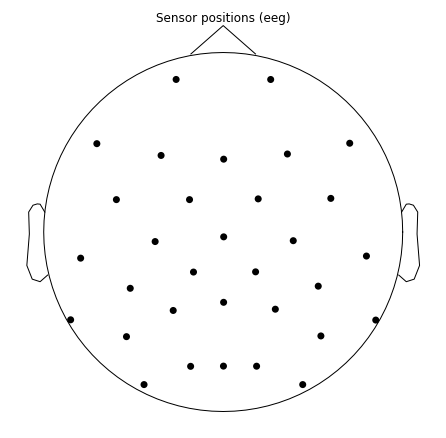

''

In [27]:
# electrodes localization in the scalp
raw.plot_sensors()
;

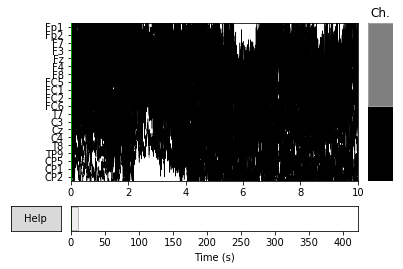

''

In [28]:
# visualization of the signals, including both EEG electrodes and events signals. 
#This is a noisy plot because data is still unfiltered
raw.plot()
;

/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


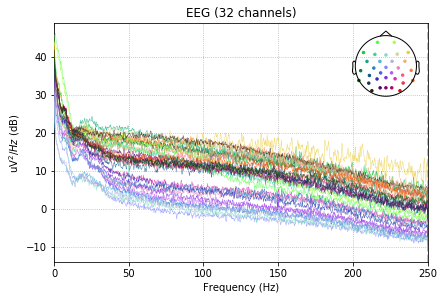

''

In [29]:

# visualization of the Power Spectral Density (PSD). 
# This computes and plots the distribution of power in function of the frequency
raw.plot_psd()
;

## Evoked potentials and data segmentation (epochs)


Subjects initiate the grasp and lift task when they observe a led turning on. This external stimulus will produce a trigger for a posible Evoked Potential (EP) that should be reflected in a temporal analysis of the EEG signals.

For this analysis, signals can be segmented in small epochs around the event of interest. The HandStart event, which indicates when the hand starts moving can be used as an approximation to the time when the subject receives the external stimulus. 



First, we try to visualize the raw data.

28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-25-42a1d494d47a>:12: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


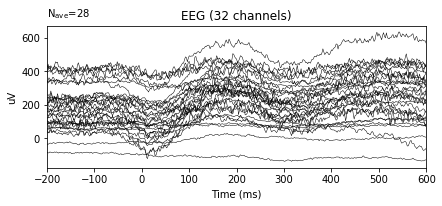

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-25-42a1d494d47a>:15: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])


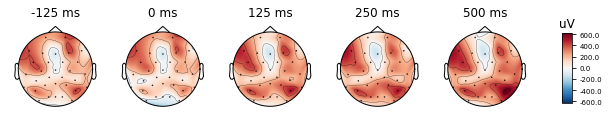

''

In [25]:
# the event of interest can be extracted from the raw object, which also contains the stimulus channels.
events = find_events(raw,stim_channel='HandStart')
# epochs are automatically built from every HandStart event. 
# Epochs length and precise position is controled with a time offset (tmin and tmax)
epochs = Epochs(raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)
                
# It is possible to compute the average epoch for each EEG, which facilitates the analysis
# and increases the signal to noise ratio
avg_epochs = epochs.average()
avg_epochs.plot()

# An a topographic map can be plot for any chosen time within the epoch
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

### Filtering signals

Now, we will filter the signals before the visualization

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-8-f676cfee900f>:17: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


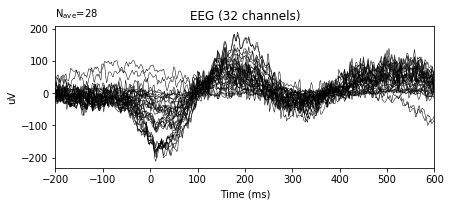

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-8-f676cfee900f>:18: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])


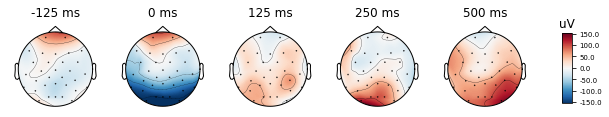

''

In [8]:
# The method filter() allows different kinds of filters to be applied, varying the l_freq and h_freq arguments.
# l_freq and h_freq are the frequencies below which and above which, respectively, to filter out of the data. 
# Thus the uses are:
#        l_freq < h_freq: band-pass filter
#        l_freq > h_freq: band-stop filter
#        l_freq is not None and h_freq is None: high-pass filter
#        l_freq is None and h_freq is not None: low-pass filter


hp_raw = raw.copy().filter(l_freq=1,h_freq=None)
hp_epochs = Epochs(hp_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)

# Visualize the result
avg_epochs = hp_epochs.average()
avg_epochs.plot()
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

### Exercise (filtering)

a) Apply a low-pass and a band-pass filter to the signals and plot the power spectral density (PSD) for both of them.

b) Which filter should we choose to improve the previous analysis? Apply that filter and compute the topographic maps as in the example above.

/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


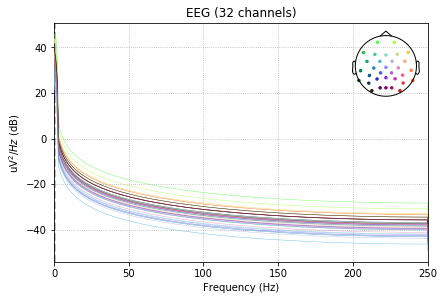

/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


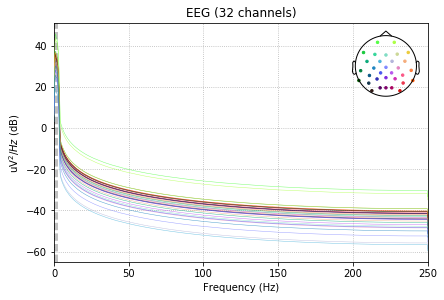

''

In [16]:
# a) Apply a low-pass and a band-pass filter to the signals and plot the power spectral density (PSD) for both of them.

# Low-pass filter:
# l_freq is None and h_freq is not None: low-pass filter

lp_raw = raw.copy().filter(l_freq=None,h_freq=1)

# Band-pass filter:
# l_freq < h_freq: band-pass filter

bp_raw = raw.copy().filter(l_freq=1,h_freq=2)


# Visualization of the Power Spectral Density (PSD):

lp_raw.plot_psd()
bp_raw.plot_psd()
;

### *Respuesta del apartado a*: 

### Para el gráfico correspondiente al PSD tras aplicar el filtro de paso bajo, a diferencia del PSD en crudo, se observa un suavizado general de las oscilaciones, de acuerdo con el análisis de aquellas variaciones de frecuencia inferior a 50 Hz y comprendida entre 150 y 250 Hz. Por tanto, se filtran artefactos relacionados con la baja frecuencia de registro de electricidad y la alta frecuencia por movimientos musculares, alcanzando un notable ajuste de la señal en base a la potencia de las diversas frecuencias.

### En el caso del PSD posterior a la aplicación del filtro de paso-banda, hay ligeras diferencias con respecto al caso anterior. Dado que el fundamento del filtro es la obtención de la media de intensidad para cada frecuencia, el ajuste a la señal devuelve en este caso una mayor separación para cada canal, lo que se asocia a la mayor amplitud si atendemos al PSD en crudo.

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-17-8b466837261b>:11: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


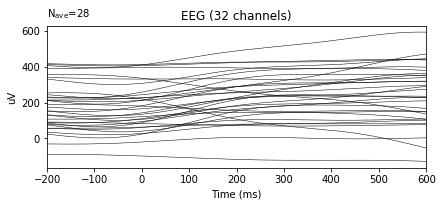

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-17-8b466837261b>:12: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])


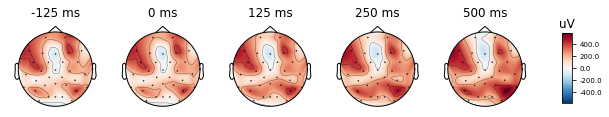

''

In [17]:
# b) Which filter should we choose to improve the previous analysis? Apply that filter and compute the topographic maps as in the example above.

# l_freq is None and h_freq is not None: low-pass filter
lp_raw = raw.copy().filter(l_freq=None,h_freq=1)
lp_epochs = Epochs(lp_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)

# Visualize the result
avg_epochs = lp_epochs.average()
avg_epochs.plot()
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-18-8342cce838a2>:10: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_bs_epochs.plot()


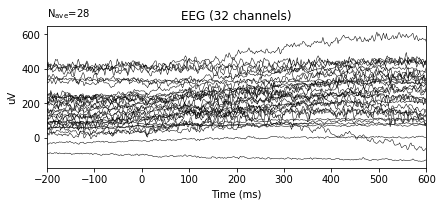

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-18-8342cce838a2>:11: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_bs_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])


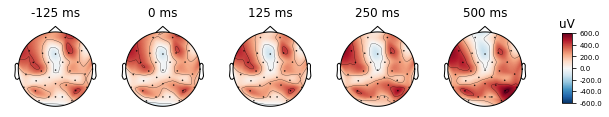

''

In [18]:
## l_freq > h_freq: band-stop filter

bs_raw = raw.copy().filter(l_freq=8,h_freq=1)
bs_epochs = Epochs(bs_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)

# Visualize the result
avg_bs_epochs = bs_epochs.average()
avg_bs_epochs.plot()
avg_bs_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-19-458ca0e75730>:9: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_bp_epochs.plot()


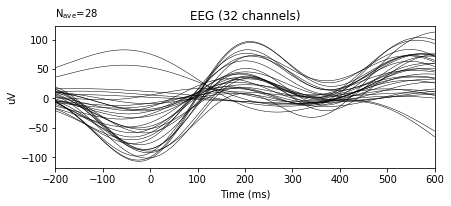

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-19-458ca0e75730>:10: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_bp_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])


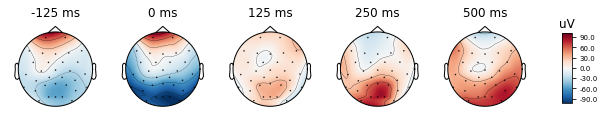

''

In [19]:
# l_freq < h_freq: band-pass filter
bp_raw = raw.copy().filter(l_freq=1,h_freq=2)
bp_epochs = Epochs(bp_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)

# Visualize the result
avg_bp_epochs = bp_epochs.average()
avg_bp_epochs.plot()
avg_bp_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

### *Respuesta del apartado b*: 
### De acuerdo con los resultados alcanzados para cada filtro aplicado, se aprecia que en el caso del filtro de paso bajo, la amplitud de las señales mantiene uniformidad para los diferentes electrodos a lo largo del tiempo analizado. El correspondiente mapa topográfico en cada caso no muestra un patrón claro, distinguiéndose un mayor contraste de señal entre electrodos con tendencia a las regiones laterales del córtex. Por su parte, el filtro de banda eliminada muestra un mapa topográfico muy similar, apreciando diferencias como la menor suavidad de las oscilaciones para la señal evaluada en ese tiempo de acuerdo con la intensidad. 

### En cuanto al filtro de paso-banda, se logra la mejor representación de variaciones en la intensidad de señal durante el tiempo para los canales, pues hay una mayor suavidad en comparación con el filtro de paso alto, que presentaba ruido. Para el mapa topográfico, se observan los contrastes entre electrodos con mayor claridad, determinando que al comienzo del evento (0 ms), el sujeto posee mayores contrastes en regiones prefrontal y corteza visual, lo que parece indicar su atención para el encendido del LED y la posterior sujeción del objeto. En base a lo expuesto, el filtro paso-banda debería elegirse para la mejora de los análisis efectuados.

## Re-referencing EEG data

The values of the EEG signals are relative to a reference. Sometimes, experiments are performed to establish the most adequate electrode to be used as reference, or electrodes are set in specific localizations for this purpose. It is also possible to chose a virtual signal as reference, e.g., the average of all the signals or a subset of them.

Applying average reference.
Applying a custom EEG reference.
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-26-f0ca80848fc0>:8: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


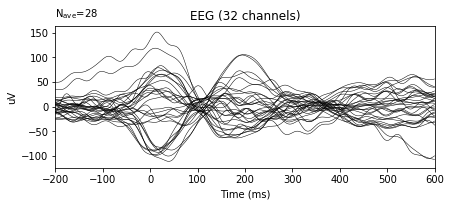

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-26-f0ca80848fc0>:9: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])


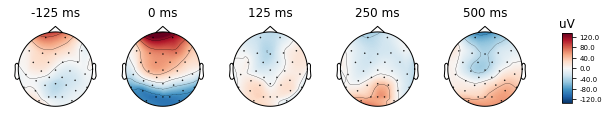

''

In [26]:
# function to change the reference of th EEG signals
_raw, _ = mne.io.set_eeg_reference(raw, ref_channels='average')
_raw = _raw.copy().filter(1,20)
epochs = Epochs(_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)
avg_epochs = epochs.average()
avg_epochs.plot()
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

It is possible to use several electrodes as reference (ref_channels=['O1','F4']).
Note that the 'Z' electrodes, placed on the midline saggital plane, are often used as reference.

Applying a custom EEG reference.
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-27-8b7b846e3992>:7: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


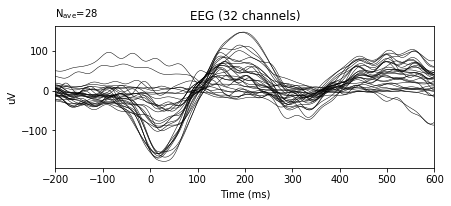

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-27-8b7b846e3992>:8: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])


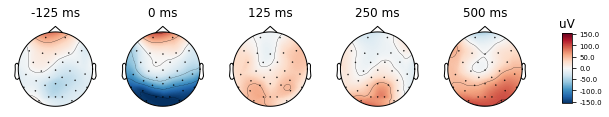

''

In [27]:
_raw, _ = mne.io.set_eeg_reference(raw,ref_channels=['Cz','Fz'])
_raw = _raw.copy().filter(1,20)
epochs = Epochs(_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)
avg_epochs = epochs.average()
avg_epochs.plot()
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

## Motor tasks and sensorimotor rhythms

Motor tasks and their mental simulation (motor imagery) produce changes in the alpha (8-13Hz) and beta (13-30Hz) rhythms.

 -Event related desynchronization (ERD)
 
 -Event related synchronization (ERS)

This should happen at the sensorimotor cortex areas, where C3, Cz and C4 electrodes are typically placed.




Now, we segment the data around actions (events) that may change these sensorimotor rhythms. For each event two epochs are obtained: before/after, before/during, etc... So basically the data is divided into two classes.
Power Spectral Density can be used to analyze the differences between these two classes and try to identify changes in the alpha and beta rhythms.

For this example we use the event 'Replace'


In [28]:
# this code is used to compute the PSD
def get_psd_from_epochs(epochs, fmin, fmax):
    psds, freqs = mne.time_frequency.psd_welch(epochs, fmin, fmax)
    psds = 10 * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    return {'mean':psds_mean, 'std':psds_std, 'freq':freqs}

1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']


<ipython-input-23-aec1cde4f3e1>:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-29-27bcc8e5e5df>:10: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


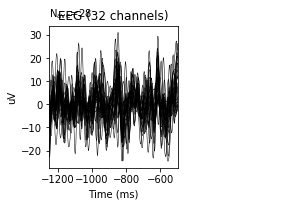

Effective window size : 0.512 (s)


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


In [29]:
raw = create_mne_raw_object_from_csv(fname)

picks = pick_types(raw.info, eeg=True) 
_raw = raw.copy().filter(7,35,picks=picks, method='iir')
events = find_events(_raw,stim_channel='Replace')
epochs = Epochs(_raw, events, {'Before' : 1}, -1.25, -0.5, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs = epochs.average()
avg_epochs.plot()

data = get_psd_from_epochs(epochs, fmin=5, fmax=35)


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-30-25138e48e1f7>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


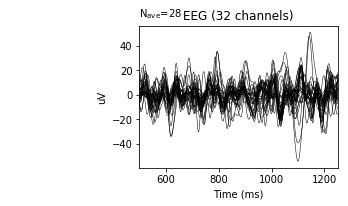

Effective window size : 0.512 (s)


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


In [30]:
epochs = Epochs(_raw, events, {'After' : 1}, 0.5, 1.25, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs = epochs.average()
avg_epochs.plot()

data1 = get_psd_from_epochs(epochs, fmin=5, fmax=35)

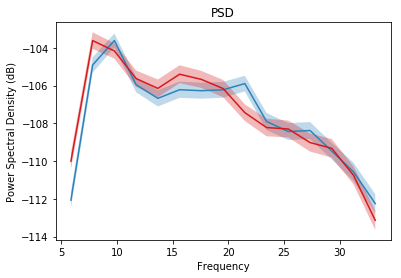

In [31]:

colors = ['#2b83ba','#d7191c','#fdae61','#fdae61', '#abdda4','#2b83ba']
plt.rcParams['axes.prop_cycle'] = cycler.cycler(color=colors)            
cgen = itertools.cycle(colors)

def plot_psds(data_list):
    fig, ax = plt.subplots()
    for data in data_list:
        ax.plot(data['freq'], data['mean'])
        ax.fill_between(data['freq'], data['mean'] - 0.1*data['std'], data['mean'] + 0.1*data['std'], alpha=.3)
    ax.set(title='PSD', xlabel='Frequency',
               ylabel='Power Spectral Density (dB)')
    plt.show()
        
plot_psds([data,data1])


## CSP

Common Spatial Patterns (CSP) is a supervised algorithm that can be applied in order to improve the distinction between both classes. CSP computes spatial filters that maximize the variance of one class while they minimize the variance of the other class. This eases the classification of the data with a subsequent classification algorithms. 

Ideally, all the subjects and series in the train dataset should be used, but this would require more computational time.


1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']


<ipython-input-23-aec1cde4f3e1>:27: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


34 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-32-20af1a2c9a25>:26: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


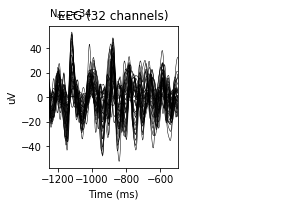

Effective window size : 0.512 (s)
34 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
<ipython-input-32-20af1a2c9a25>:35: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs.plot()


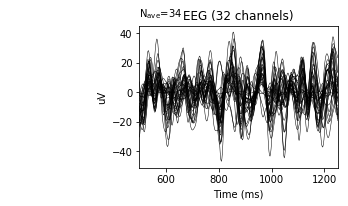

Effective window size : 0.512 (s)


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


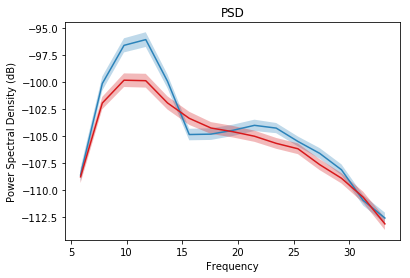

In [32]:
#This part repeats the same analysis

#subject=2
#serie=5
#fnames = glob('/home/ashvaro/Neuroengineering/train/subj%d_series%d_data.csv' % (subject, serie))


#raws = [create_mne_raw_object_from_csv(fname) for fname in fnames]
#raw = mne.concatenate_raws(raws)

subject=2
serie=5
fname = './train/subj%d_series%d_data.csv' % (subject,serie)
raw = create_mne_raw_object_from_csv(fname)

picks = pick_types(raw.info, eeg=True) 
_raw = raw.copy().filter(7,35,picks=picks, method='iir')
events = find_events(_raw,stim_channel='Replace')

#picks = [raw.ch_names.index(ch) for ch in ['Cz', 'Pz', 'C3', 'C4']]
epochs = Epochs(_raw, events, {'Before' : 1}, -1.25, -0.5, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)

avg_epochs = epochs.average()
avg_epochs.plot()

psd_before = get_psd_from_epochs(epochs, fmin=5, fmax=35)

events = find_events(_raw,stim_channel='Replace')
epochs1 = Epochs(_raw, events, {'After' : 1}, 0.5, 1.25, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs = epochs1.average()
avg_epochs.plot()

psd_after = get_psd_from_epochs(epochs1, fmin=5, fmax=35)

plot_psds([psd_before,psd_after])

CSP

This is a supervised algorithm and, therefore, it requires the use of annotated data for the training phase.

Label 1 is used for epochs before the event and label 0 for epochs after the event.



Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


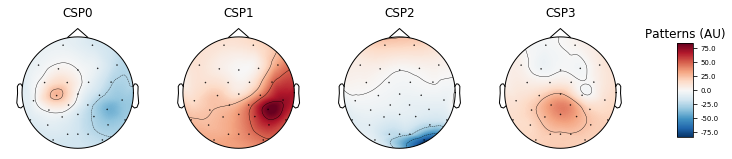

''

In [33]:
#CSP
#concatenate all epochs (X) and set labels (y).
y = [1]*len(epochs) + [0]*len(epochs1)

# get data 
X = np.concatenate((epochs.get_data(),epochs1.get_data()))
y = np.array(y)

# run CSP
csp = CSP()
csp.fit(X,y)

csp.plot_patterns(epochs.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)
;

CSP computes several filters that can be applied to the signals. This results in different spatial patterns detected in the data. 

The code below serves to visualize the spatial pattern for the first filter and to compute the PSD when that pattern is applied to the data.

/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 512 is greater than input length  = 376, using nperseg = 376
  .format(nperseg, input_length))


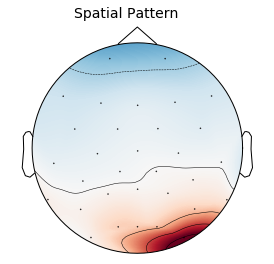

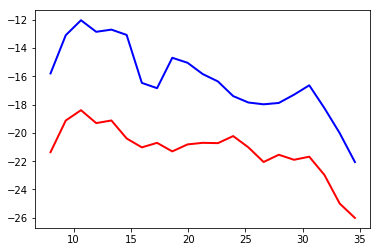

In [34]:
n_pattern=2

# compute spatial filtered spectrum
# The code is different because here PSD is computed from numpy arrays, 
# instead of the objects in the MNE package
po = []
for x in X:
    f,p = welch(np.dot(csp.filters_[n_pattern,:].T,x), 500, nperseg=512)
    po.append(p)
po = np.array(po)


# plot first pattern
pattern = csp.patterns_[n_pattern,:]
pattern -= pattern.mean()
ix = np.argmax(abs(pattern))
# the parttern is sign invariant.
# invert it for display purpose
if pattern[ix]>0:
    sign = 1.0
else:
    sign = -1.0

fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
title = 'Spatial Pattern'
fig.suptitle(title, fontsize=14)
img, _ = plot_topomap(sign*pattern,epochs.info,axes=ax_topo) #,show=False)

#plt.colorbar(img, cax=ax_colorbar)

# plot spectrum
fix = (f>7) & (f<35)


fig, ax = plt.subplots()
plt.plot(f[fix],10*np.log10(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
plt.plot(f[fix],10*np.log10(po[y==0][:,fix].mean(axis=0).T),'-b',lw=2)
plt.show()

### Exercise (CSP):

a) Perform the same analysis for the subject 1. How are the results compared with subject 2? Why do you think this happens?


1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']


<ipython-input-2-5b66224a4a4f>:29: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-5-7b7e9ae2119c>:15: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs_sub1.plot()


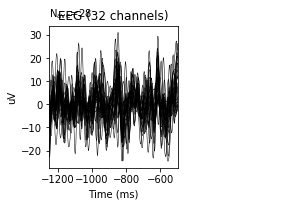

Effective window size : 0.512 (s)
28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
<ipython-input-5-7b7e9ae2119c>:24: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs2.plot()


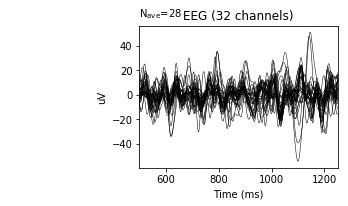

Effective window size : 0.512 (s)


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


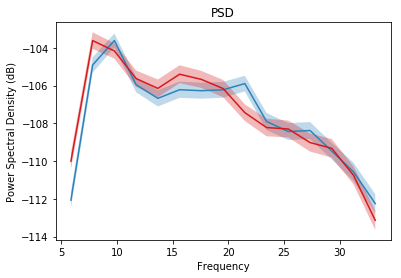

In [5]:
subject=1
serie=5
fname_sub1 = './train/subj%d_series%d_data.csv' % (subject,serie)
raw_sub1 = create_mne_raw_object_from_csv(fname_sub1)

picks_sub1 = pick_types(raw_sub1.info, eeg=True) 
_raw_sub1 = raw_sub1.copy().filter(7,35,picks=picks_sub1, method='iir')
events_sub1 = find_events(_raw_sub1,stim_channel='Replace')

epochs_sub1 = Epochs(_raw_sub1, events_sub1, {'Before' : 1}, -1.25, -0.5, picks=picks_sub1, proj=False,
                        baseline=None, preload=True,
                        verbose=False)

avg_epochs_sub1 = epochs_sub1.average()
avg_epochs_sub1.plot()

psd_before_sub1 = get_psd_from_epochs(epochs_sub1, fmin=5, fmax=35)

events_sub1 = find_events(_raw_sub1,stim_channel='Replace')
epochs2 = Epochs(_raw_sub1, events_sub1, {'After' : 1}, 0.5, 1.25, picks=picks_sub1, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs2 = epochs2.average()
avg_epochs2.plot()

psd_after_sub1 = get_psd_from_epochs(epochs2, fmin=5, fmax=35)

plot_psds([psd_before_sub1,psd_after_sub1])

### Mediante el Power Spectral Density (PSD), se determinan las diferencias entre clases, es decir, epochs previa y posterior, identificando los cambios en las ondas alfa (8-13 Hz) y beta (13-30 Hz). Debemos tener en cuenta que está centrado en el evento “Replace”, es decir, cuando el sujeto vuelve a colocar el objeto a su posición original tras sujetarlo, elevarlo y mantenerlo en el aire durante 2 segundos. En azul, se refleja el caso previo, mientras que en rojo se hace referencia al caso posterior. Se pueden observar bandas de 8 a 30 Hz con menos potencia antes que después. Esto es fundamentalmente un análisis en base a todos los electrodos de trabajo, de modo que se aprecia una desincronización previa y sincronización posterior, recogida con una reducción de señal previa y posterior ampliación del potencial de señal.

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


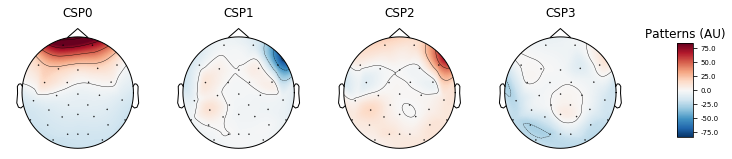

''

In [7]:
#CSP
#concatenate all epochs (X) and set labels (y).
y = [1]*len(epochs_sub1) + [0]*len(epochs2)

# get data 
X = np.concatenate((epochs_sub1.get_data(),epochs2.get_data()))
y = np.array(y)

# run CSP
csp = CSP()
csp.fit(X,y)

csp.plot_patterns(epochs_sub1.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)
;

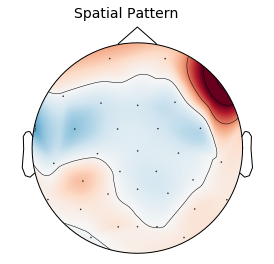

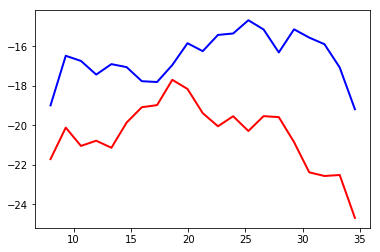

In [9]:
n_pattern=2

# compute spatial filtered spectrum
# The code is different because here PSD is computed from numpy arrays, 
# instead of the objects in the MNE package
po = []
for x in X:
    f,p = welch(np.dot(csp.filters_[n_pattern,:].T,x), 500, nperseg=512)
    po.append(p)
po = np.array(po)


# plot first pattern
pattern = csp.patterns_[n_pattern,:]
pattern -= pattern.mean()
ix = np.argmax(abs(pattern))
# the parttern is sign invariant.
# invert it for display purpose
if pattern[ix]>0:
    sign = 1.0
else:
    sign = -1.0

fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
title = 'Spatial Pattern'
fig.suptitle(title, fontsize=14)
img, _ = plot_topomap(sign*pattern,epochs_sub1.info,axes=ax_topo) #,show=False)

#plt.colorbar(img, cax=ax_colorbar)

# plot spectrum
fix = (f>7) & (f<35)


fig, ax = plt.subplots()
plt.plot(f[fix],10*np.log10(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
plt.plot(f[fix],10*np.log10(po[y==0][:,fix].mean(axis=0).T),'-b',lw=2)
plt.show()

### *Respuesta del ejercicio (CSP)*:

### Al concatenar los epochs y establecer las correspondientes etiquetas para dicho algoritmo supervisado (1 para caso anterior y 0 para posterior), se determinan los patrones. El primero (CSP0) es de mayor relevancia, pues realza la región frontal en concreto por el mayor contraste entre electrodos. Atendiendo al CSP0 como filtro espacial, vemos desincronización previa y sincronización posterior, que se maximiza en base a la diferencia existente en torno a la región dorsolateral. Este resultado podría deberse a que el sujeto percibe un cambio en la condición de la prueba, como podría ser el incremento en peso del objeto o cambio en tipo de superficie donde se deposita (papel de lija, ante o seda), con la intención de un ajuste en la fuerza aplicada, de ahí ese contraste en la región del patrón espacial cercana al canal C4, asociada a sensaciones, intención y acción en sentido amplio. Por tanto, a diferencia de esto, el sujeto 2 se trataría de un caso donde se lleva a cabo el procedimiento con una notable observación del objeto en su transcurso, tal y como se refleja en el mayor contraste logrado en la región visual del córtex.

## Classification

In [51]:
# Classification using LDA and CSP
lda = LinearDiscriminantAnalysis() #Classification algorithm (supervised)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False) #Signal processing algorithm (supervised)

# Use scikit-learn Pipeline
clf = Pipeline([('CSP', csp), ('LDA', lda)])

#We use a fixed train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
clf.fit(x_train, y_train)

test_score = clf.score(x_test, y_test)
print('Test accuracy: ',test_score)

train_score = clf.score(x_train, y_train)
print('Train accuracy: ',train_score)


# Accuracy by chance
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print('Classification accuracy by chance: ' + str(class_balance))

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Test accuracy:  0.9411764705882353
Train accuracy:  0.9803921568627451
Classification accuracy by chance: 0.5294117647058824


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


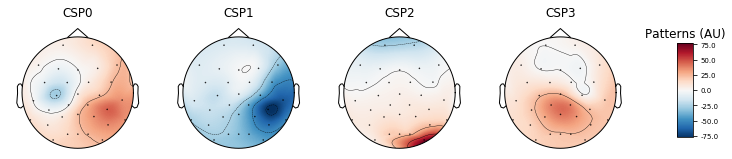

''

In [18]:

csp.plot_patterns(epochs.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)
;

### Exercise (Classification)

For subject 2:
    
b) Perform the same CSP analysis with the event 'HandStart' instead of 'Replace'. In this case there is a class with no movement (before the event) and a class with movement (after the event). It could be adequate to change the length of the epochs.

c) Perform the classification of the signal using the same "pipeline" that we have used before (CSP and LDA). Additionally, measure the peformance (score) when the classification is trained and evaluated on different subjects. How is the performance in comparison?

In [2]:
## Funciones auxiliares:
# Custom function for loading data from csv to MNE
def create_mne_raw_object_from_csv(fname):
    f_events = fname.replace('_data','_events')
    
    # read EEG file (csv) using Pandas
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)

    # read event file
    events = pd.read_csv(f_events)
    events_names = events.columns[1:]
    events_data = np.array(events[events_names]).T
    
    # concatenate event file and data
    data = np.concatenate((1e-6*np.array(data[ch_names]).T,events_data))        
    
    # define channel type, the first is EEG, the last 6 are stimulations
    ch_type = ['eeg']*len(ch_names) + ['stim']*6
    
    # create and populate MNE info structure
    ch_names.extend(events_names)
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    return raw

# this code is used to compute the PSD
def get_psd_from_epochs(epochs, fmin, fmax):
    psds, freqs = mne.time_frequency.psd_welch(epochs, fmin, fmax)
    psds = 10 * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    return {'mean':psds_mean, 'std':psds_std, 'freq':freqs}

# Plot PSD
colors = ['#2b83ba','#d7191c','#fdae61','#fdae61', '#abdda4','#2b83ba']
plt.rcParams['axes.prop_cycle'] = cycler.cycler(color=colors)            
cgen = itertools.cycle(colors)

def plot_psds(data_list):
    fig, ax = plt.subplots()
    for data in data_list:
        ax.plot(data['freq'], data['mean'])
        ax.fill_between(data['freq'], data['mean'] - 0.1*data['std'], data['mean'] + 0.1*data['std'], alpha=.3)
    ax.set(title='PSD', xlabel='Frequency',
               ylabel='Power Spectral Density (dB)')
    plt.show()

1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']


<ipython-input-2-5b66224a4a4f>:29: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


34 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-5-4d7861e50020>:20: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs_2.plot()


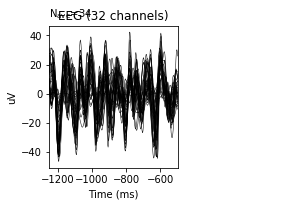

Effective window size : 0.512 (s)
34 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
<ipython-input-5-4d7861e50020>:29: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs_2.plot()


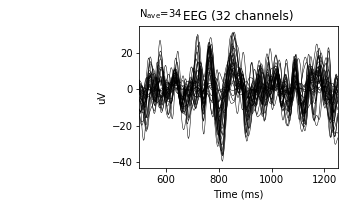

Effective window size : 0.512 (s)


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


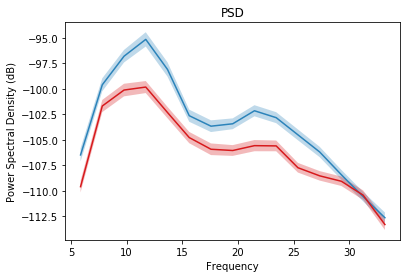

In [5]:
# SUJETO 2: EVENTO 'HandStart':
subject_2=2
serie_2=5
fname_2 = './train/subj%d_series%d_data.csv' % (subject_2,serie_2)
raw_2 = create_mne_raw_object_from_csv(fname_2)

picks_2 = pick_types(raw_2.info, eeg=True) 
_raw_2 = raw_2.copy().filter(7,35,picks=picks_2, method='iir')
events_2 = find_events(_raw_2,stim_channel='HandStart')

#picks = [raw.ch_names.index(ch) for ch in ['Cz', 'Pz', 'C3', 'C4']]
epochs_2 = Epochs(_raw_2, events_2, {'Before' : 1}, -1.25, -0.5, picks=picks_2, proj=False,
                        baseline=None, preload=True,
                        verbose=False)

avg_epochs_2 = epochs_2.average()
avg_epochs_2.plot()

psd_before_2 = get_psd_from_epochs(epochs_2, fmin=5, fmax=35)

events2_2 = find_events(_raw_2,stim_channel='HandStart')
epochs1_2 = Epochs(_raw_2, events_2, {'After' : 1}, 0.5, 1.25, picks=picks_2, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs_2 = epochs1_2.average()
avg_epochs_2.plot()

psd_after_2 = get_psd_from_epochs(epochs1_2, fmin=5, fmax=35)

plot_psds([psd_before_2,psd_after_2])


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


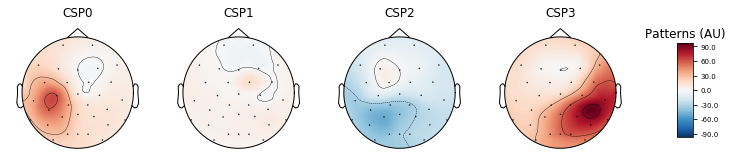

''

In [6]:
#CSP
#concatenate all epochs (X) and set labels (y).
y_2 = [1]*len(epochs_2) + [0]*len(epochs1_2)

# get data 
X_2 = np.concatenate((epochs_2.get_data(),epochs1_2.get_data()))
y_2 = np.array(y_2)

# run CSP
csp_2 = CSP()
csp_2.fit(X_2,y_2)

csp_2.plot_patterns(epochs_2.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)
;

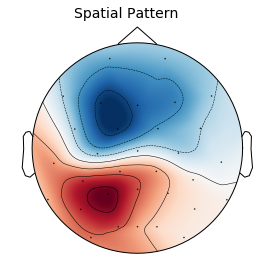

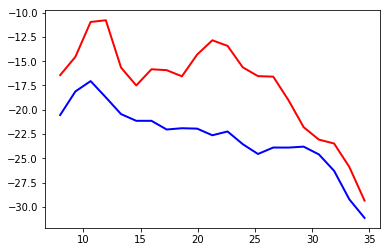

In [8]:
n_pattern=2

# compute spatial filtered spectrum
# The code is different because here PSD is computed from numpy arrays, 
# instead of the objects in the MNE package
po2 = []
for x in X_2:
    f2,p2 = welch(np.dot(csp_2.filters_[n_pattern,:].T,x), 500, nperseg=512)
    po2.append(p2)
po2 = np.array(po2)


# plot first pattern
pattern2 = csp_2.patterns_[n_pattern,:]
pattern2 -= pattern2.mean()
ix2 = np.argmax(abs(pattern2))
# the parttern is sign invariant.
# invert it for display purpose
if pattern2[ix2]>0:
    sign = 1.0
else:
    sign = -1.0

fig2, ax_topo2 = plt.subplots(1, 1, figsize=(12, 4))
title2 = 'Spatial Pattern'
fig2.suptitle(title2, fontsize=14)
img2, _ = plot_topomap(sign*pattern2,epochs_2.info,axes=ax_topo2) #,show=False)

#plt.colorbar(img, cax=ax_colorbar)

# plot spectrum
fix2 = (f2>7) & (f2<35)


fig2, ax2 = plt.subplots()
plt.plot(f2[fix2],10*np.log10(po2[y_2==1][:,fix2].mean(axis=0).T),'-r',lw=2)
plt.plot(f2[fix2],10*np.log10(po2[y_2==0][:,fix2].mean(axis=0).T),'-b',lw=2)
plt.show()

In [11]:
## Clasificación de la señal en el sujeto 2 con LDA y CSP:

# Classification using LDA and CSP
lda2 = LinearDiscriminantAnalysis() #Classification algorithm (supervised)
csp2 = CSP(n_components=4, reg=None, log=True, norm_trace=False) #Signal processing algorithm (supervised)

# Use scikit-learn Pipeline
clf2 = Pipeline([('CSP', csp2), ('LDA', lda2)])

#We use a fixed train-test split
x_train2, x_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.25) 
clf2.fit(x_train2, y_train2)

test_score2 = clf2.score(x_test2, y_test2)
print('Test accuracy (subject 2): ',test_score2)

train_score2 = clf2.score(x_train2, y_train2)
print('Train accuracy (subject 2): ',train_score2)


# Accuracy by chance
class_balance2 = np.mean(y_test2 == y_test2[0])
class_balance2 = max(class_balance2, 1. - class_balance2)
print('Classification accuracy by chance (subject 2): ' + str(class_balance2))

# Monte-carlo cross-validation:
cv2 = ShuffleSplit(10, test_size=0.2, random_state=42)
cv2_split = cv2.split(X_2)
;

scores_sub2_hs = cross_val_score(clf2, X_2, y_2, cv=cv2, n_jobs=1)

print('El score alcanzado para la clasificación en el individuo 2 es: ', np.mean(scores_sub2_hs))

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Test accuracy (subject 2):  0.8823529411764706
Train accuracy (subject 2):  0.9607843137254902
Classification accuracy by chance (subject 2): 0.6470588235294118
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(li

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(li

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(li

Estimating covariance using EMPIRICAL
Done.
El score alcanzado para la clasificación en el individuo 2 es:  0.9214285714285715


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']


<ipython-input-2-5b66224a4a4f>:29: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-12-aa058261446e>:20: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs_1.plot()


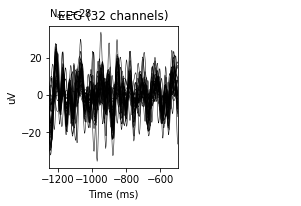

Effective window size : 0.512 (s)
28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
<ipython-input-12-aa058261446e>:29: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  avg_epochs_1.plot()


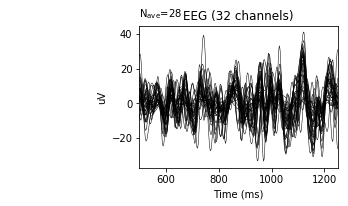

Effective window size : 0.512 (s)


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


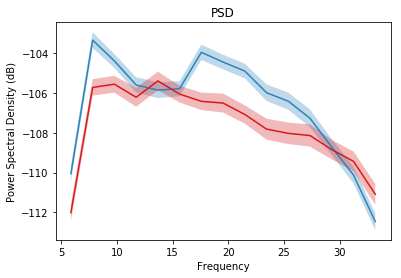

In [12]:
# SUJETO 1: EVENTO 'HandStart':
subject_1=1
serie_1=5
fname_1 = './train/subj%d_series%d_data.csv' % (subject_1,serie_1)
raw_1 = create_mne_raw_object_from_csv(fname_1)

picks_1 = pick_types(raw_1.info, eeg=True) 
_raw_1 = raw_1.copy().filter(7,35,picks=picks_1, method='iir')
events_1 = find_events(_raw_1,stim_channel='HandStart')

#picks = [raw.ch_names.index(ch) for ch in ['Cz', 'Pz', 'C3', 'C4']]
epochs_1 = Epochs(_raw_1, events_1, {'Before' : 1}, -1.25, -0.5, picks=picks_1, proj=False,
                        baseline=None, preload=True,
                        verbose=False)

avg_epochs_1 = epochs_1.average()
avg_epochs_1.plot()

psd_before_1 = get_psd_from_epochs(epochs_1, fmin=5, fmax=35)

events2_1 = find_events(_raw_1,stim_channel='HandStart')
epochs1_1 = Epochs(_raw_1, events_1, {'After' : 1}, 0.5, 1.25, picks=picks_1, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs_1 = epochs1_1.average()
avg_epochs_1.plot()

psd_after_1 = get_psd_from_epochs(epochs1_1, fmin=5, fmax=35)

plot_psds([psd_before_1,psd_after_1])

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)


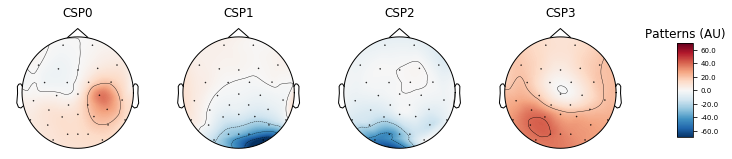

''

In [13]:
#CSP
#concatenate all epochs (X) and set labels (y).
y_1 = [1]*len(epochs_1) + [0]*len(epochs1_1)

# get data 
X_1 = np.concatenate((epochs_1.get_data(),epochs1_1.get_data()))
y_1 = np.array(y_1)

# run CSP
csp_1 = CSP()
csp_1.fit(X_1,y_1)

csp_1.plot_patterns(epochs_1.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)
;

/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 512 is greater than input length  = 376, using nperseg = 376
  .format(nperseg, input_length))


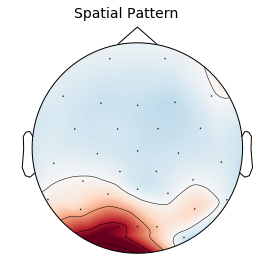

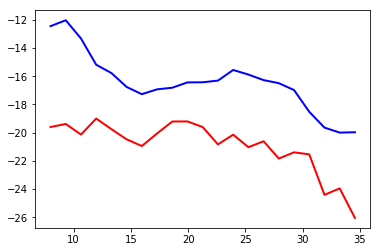

In [14]:
n_pattern=2

# compute spatial filtered spectrum
# The code is different because here PSD is computed from numpy arrays, 
# instead of the objects in the MNE package
po1 = []
for x in X_1:
    f1,p1 = welch(np.dot(csp_1.filters_[n_pattern,:].T,x), 500, nperseg=512)
    po1.append(p1)
po1 = np.array(po1)


# plot first pattern
pattern1 = csp_1.patterns_[n_pattern,:]
pattern1 -= pattern1.mean()
ix1 = np.argmax(abs(pattern1))
# the parttern is sign invariant.
# invert it for display purpose
if pattern1[ix1]>0:
    sign = 1.0
else:
    sign = -1.0

fig1, ax_topo1 = plt.subplots(1, 1, figsize=(12, 4))
title1 = 'Spatial Pattern'
fig1.suptitle(title1, fontsize=14)
img1, _ = plot_topomap(sign*pattern1,epochs_1.info,axes=ax_topo1) #,show=False)

#plt.colorbar(img, cax=ax_colorbar)

# plot spectrum
fix1 = (f1>7) & (f1<35)


fig1, ax1 = plt.subplots()
plt.plot(f1[fix1],10*np.log10(po1[y_1==1][:,fix1].mean(axis=0).T),'-r',lw=2)
plt.plot(f1[fix1],10*np.log10(po1[y_1==0][:,fix1].mean(axis=0).T),'-b',lw=2)
plt.show()

In [19]:
## Clasificación de la señal en el sujeto 1 con LDA y CSP:

# Classification using LDA and CSP
lda1 = LinearDiscriminantAnalysis() #Classification algorithm (supervised)
csp1 = CSP(n_components=4, reg=None, log=True, norm_trace=False) #Signal processing algorithm (supervised)

# Use scikit-learn Pipeline
clf1 = Pipeline([('CSP', csp1), ('LDA', lda1)])

#We use a fixed train-test split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.25) 
clf1.fit(x_train1, y_train1)

test_score1 = clf1.score(x_test1, y_test1)
print('Test accuracy (subject 1): ',test_score1)

train_score1 = clf1.score(x_train1, y_train1)
print('Train accuracy (subject 1): ',train_score1)


# Accuracy by chance
class_balance1 = np.mean(y_test1 == y_test1[0])
class_balance1 = max(class_balance1, 1. - class_balance1)
print('Classification accuracy by chance (subject 1): ' + str(class_balance1))

# Monte-carlo cross-validation:
cv1 = ShuffleSplit(10, test_size=0.2, random_state=42)
cv1_split = cv1.split(X_1)
;

scores_sub1_hs = cross_val_score(clf1, X_1, y_1, cv=cv1, n_jobs=1)

print('El score alcanzado para la clasificación en el individuo 1 es: ', np.mean(scores_sub1_hs))

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Test accuracy (subject 1):  0.9285714285714286
Train accuracy (subject 1):  0.9761904761904762
Classification accuracy by chance (subject 1): 0.5714285714285714
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(li

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(

Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
El score alcanzado para la clasificación en el individuo 1 es:  1.0


/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/mne/utils.py:1099: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  this_version = LooseVersion(library.__version__)
/Users/pedrosanchezgarcia/Desktop/MUBICS_UDC/NIN/Material/nin/lib/python3.7/site-packages/sklearn/utils/validation.py:204: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(

### *Respuesta del ejercicio (Clasificación)*:

### En base a los resultados alcanzados para la clasificación previa/posterior mediante LDA del evento en cuestión, se aprecia que en el caso del sujeto 2 hay una precisión superior (0.647) en comparación con el sujeto 1 (0.571). No obstante, para este último, se alcanza un valor de 1 para el rendimiento bajo la validación Monte-carlo frente a 0.921 con el sujeto 2. De esta forma, en ambos sujetos, el clasificador proporciona una precisión que no resulta elevada, lo que podría mejorar con un mayor conjunto de epochs y balance de las clases tratadas. Cabe destacar que el valor de rendimiento para el sujeto 1 parece indicar un sobreajuste del modelo, lo que podría deberse a un mayor impacto de los factores mencionados por el clasificador para ese caso. 	